In [1]:
"*ein: http://127.0.0.1:8899/make_figs.ipynb*"
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*<2>"))

SyntaxError: invalid syntax (<ipython-input-1-7bcf22491de6>, line 2)

In [2]:
%pylab inline
import os,sys
import pickle
from importlib import reload
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft

Populating the interactive namespace from numpy and matplotlib


In [67]:
PLOT = True # Whether to actually make the plots

In [4]:
import boulder;                         reload(boulder)
import crick;                           reload(crick)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
FisherPlumes = fp.FisherPlumes

force_reload = True
if force_reload or ('Fbw' not in locals()):
    pairs_mode = "unsigned"
    Fbw = FisherPlumes("boulder16", which_coords = [(0.45, 0.5)], py_mode = "relative", suffix = 'wideDomain.old',pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
    Fcr = FisherPlumes("n12dishT",  which_coords = [(1.0, 0.5)], pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
else:
    Fbw = FisherPlumes(Fbw)
    Fcr = FisherPlumes(Fcr)
    
data = {
    "cr":Fcr,
    "bw":Fbw
}

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


           fisher_plumes 2022/10/19 06:12:23     INFO: ****** LOADING sim_name='boulder16' ******


     fisher_plumes_tools 2022/10/19 06:12:23     INFO: Using relative py coordinates.


     fisher_plumes_tools 2022/10/19 06:12:23     INFO: Loading data from file_name='Re100_0_5mm_50Hz_16source_wideDomain.old.h5'.


INFO:boulder:
Re100_0_5mm_50Hz_16source_wideDomain.old.h5 <BoulderSimulationData>
x_lim: [0.0, 0.5]
y_lim: [-0.21125, 0.21125]
x-y Dimensions: [0.5    0.4225]
x-range: 0.000, 0.001 ... 0.500 (1001 points)
y-range: 0.211, 0.211 ... -0.211 (846 points)
t-range: 0.000, 0.020 ... 60.000 (3001 points)
fs: 50 Hz
Sources:
  0: =    c1a @ (x = +0, y = +0.00375)
  1: =    c1b @ (x = +0, y = -0.00375)
  2: =    c2a @ (x = +0, y = +0.01125)
  3: =    c2b @ (x = +0, y = -0.01125)
  4: =    c3a @ (x = +0, y = +0.01875)
  5: =    c3b @ (x = +0, y = -0.01875)
  6: =    c4a @ (x = +0, y = +0.02625)
  7: =    c4b @ (x = +0, y = -0.02625)
  8: =    c5a @ (x = +0, y = +0.03375)
  9: =    c5b @ (x = +0, y = -0.03375)
 10: =    c6a @ (x = +0, y = +0.04125)
 11: =    c6b @ (x = +0, y = -0.04125)
 12: =    c7a @ (x = +0, y = +0.04875)
 13: =    c7b @ (x = +0, y = -0.04875)
 14: =    c8a @ (x = +0, y = +0.05625)
 15: =    c8b @ (x = +0, y = -0.05625)


     fisher_plumes_tools 2022/10/19 06:12:23  WARNING: Doubling y coordinates because they were wrong in the original data.


INFO:boulder:Mapped coordinate ( 0.450,  0.000) to ( 0.450,  0.000), index (900, 422), name 'x=45 cm'.


INFO:boulder:Field c1a has shape (3001, 1).


INFO:boulder:Field c1b has shape (3001, 1).


INFO:boulder:Field c2a has shape (3001, 1).


INFO:boulder:Field c2b has shape (3001, 1).


INFO:boulder:Field c3a has shape (3001, 1).


INFO:boulder:Field c3b has shape (3001, 1).


INFO:boulder:Field c4a has shape (3001, 1).


INFO:boulder:Field c4b has shape (3001, 1).


INFO:boulder:Field c5a has shape (3001, 1).


INFO:boulder:Field c5b has shape (3001, 1).


INFO:boulder:Field c6a has shape (3001, 1).


INFO:boulder:Field c6b has shape (3001, 1).


INFO:boulder:Field c7a has shape (3001, 1).


INFO:boulder:Field c7b has shape (3001, 1).


INFO:boulder:Field c8a has shape (3001, 1).


INFO:boulder:Field c8b has shape (3001, 1).


     fisher_plumes_tools 2022/10/19 06:13:11     INFO: Computing pairs for len(yvals)=16 from -112500 to 112500 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/19 06:13:11     INFO: Removing duplicates in pairs dictionary.


           fisher_plumes 2022/10/19 06:13:11     INFO: ****** LOADING sim_name='n12dishT' ******


     fisher_plumes_tools 2022/10/19 06:13:11     INFO: load_sims for sim_name='n12dishT' with which_coords=[(1.0, 0.5)] (py_mode='absolute').


     fisher_plumes_tools 2022/10/19 06:13:11     INFO: Using absolute py coordinates.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.450


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.480


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.490


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=1 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.550


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.502


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.520


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.505


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.495


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.500


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.498


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.510


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-1 cm.


     fisher_plumes_tools 2022/10/19 06:13:21     INFO: Yvals: [450000, 480000, 490000, 495000, 498000, 500000, 502000, 505000, 510000, 520000, 550000]


     fisher_plumes_tools 2022/10/19 06:13:21     INFO: Computing distance pairings.


     fisher_plumes_tools 2022/10/19 06:13:21     INFO: Computing pairs for len(yvals)=11 from 450000 to 550000 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/19 06:13:21     INFO: Removing duplicates in pairs dictionary.


     fisher_plumes_tools 2022/10/19 06:13:21     INFO: 24 distance pairings found, from 0 to 100000


# Compute all the statistics

In [5]:
wnd_sec = 1.
dmax    = {"bw":np.inf, "cr":np.inf}
wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
[(print(k, end = ""), sys.stdout.flush(), F.compute_all_for_window(wnd = wnd[k],
                                                                   istart = istart[k],
                                                                   window = 'boxcar',
                                                                   tukey_param = 0,
                                                                   dmax = dmax[k],
                                                                   fit_amps = False,                                                                  
)) for k, F in data.items()];

cr

           fisher_plumes 2022/10/19 06:13:21     INFO: Window set to self.wnd=1000.


           fisher_plumes 2022/10/19 06:13:21     INFO: Computing trig coefficients for n12dishT with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/19 06:13:23     INFO: Computing amplitude of generalized gaussian fits to λ(s).


           fisher_plumes 2022/10/19 06:13:24     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/19 06:13:34     INFO: Computing lambdas.


           fisher_plumes 2022/10/19 06:13:34     INFO: Creating pooling functions.


           fisher_plumes 2022/10/19 06:14:08     INFO: Computing p-values.


           fisher_plumes 2022/10/19 06:14:08     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/19 06:14:24     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/19 06:14:24     INFO: Using 24 distances <= inf


           fisher_plumes 2022/10/19 06:14:24     INFO: Computed λ for 501 frequencies and 24 distances and 51 bootstraps.


           fisher_plumes 2022/10/19 06:14:24     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/19 06:14:45    DEBUG: self.fit_params.shape=(51, 501, 2).


bw

/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:195: RuntimeWarning: divide by zero encountered in power
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:195: RuntimeWarning: divide by zero encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:195: RuntimeWarning: invalid value encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
           fisher_plumes 2022/10/19 06:14:45     INFO: Window set to self.wnd=50.


           fisher_plumes 2022/10/19 06:14:45     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/19 06:14:45     INFO: Computing amplitude of generalized gaussian fits to λ(s).


           fisher_plumes 2022/10/19 06:14:45     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/19 06:14:46     INFO: Computing lambdas.


           fisher_plumes 2022/10/19 06:14:46     INFO: Creating pooling functions.


           fisher_plumes 2022/10/19 06:14:47     INFO: Computing p-values.


           fisher_plumes 2022/10/19 06:14:47     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/19 06:14:48     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/19 06:14:48     INFO: Using 16 distances <= inf


           fisher_plumes 2022/10/19 06:14:48     INFO: Computed λ for 26 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2022/10/19 06:14:48     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/19 06:14:50    DEBUG: self.fit_params.shape=(51, 26, 2).


# Figure showing an example plume and correlations

INFO:boulder:Loading fld='c1a' at t=40 from full_file='./data/c1a_t40.p'.


INFO:boulder:Loading fld='c1b' at t=40 from full_file='./data/c1b_t40.p'.


INFO:boulder:Loading fld='c2a' at t=40 from full_file='./data/c2a_t40.p'.


INFO:boulder:Loading fld='c2b' at t=40 from full_file='./data/c2b_t40.p'.


INFO:boulder:Loading fld='c3a' at t=40 from full_file='./data/c3a_t40.p'.


INFO:boulder:Loading fld='c3b' at t=40 from full_file='./data/c3b_t40.p'.


INFO:boulder:Loading fld='c4a' at t=40 from full_file='./data/c4a_t40.p'.


INFO:boulder:Loading fld='c4b' at t=40 from full_file='./data/c4b_t40.p'.


INFO:boulder:Loading fld='c5a' at t=40 from full_file='./data/c5a_t40.p'.


INFO:boulder:Loading fld='c5b' at t=40 from full_file='./data/c5b_t40.p'.


INFO:boulder:Loading fld='c6a' at t=40 from full_file='./data/c6a_t40.p'.


INFO:boulder:Loading fld='c6b' at t=40 from full_file='./data/c6b_t40.p'.


INFO:boulder:Loading fld='c7a' at t=40 from full_file='./data/c7a_t40.p'.


INFO:boulder:Loading fld='c7b' at t=40 from full_file='./data/c7b_t40.p'.


INFO:boulder:Loading fld='c8a' at t=40 from full_file='./data/c8a_t40.p'.


INFO:boulder:Loading fld='c8b' at t=40 from full_file='./data/c8b_t40.p'.


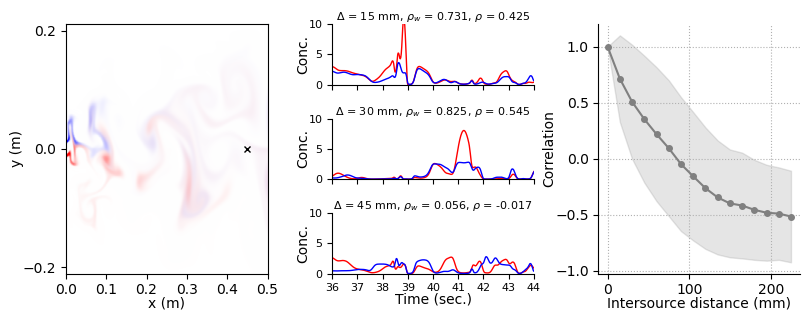

In [6]:
reload(fpf)
ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(Fbw, 40, [-7500, 7500], y_lim = (0,10.01), dt = 1)
ax_plume.set_yticks([-0.2, 0, 0.2])
file_name = f"figs/plumes_demo_bw.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y450_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y480_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y490_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y550_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y502_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y520_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y505_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y495_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y500_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y498_S1_t40.p'.


INFO:crick:Loading fld='S1' at t=40 from full_file='./data/y510_S1_t40.p'.


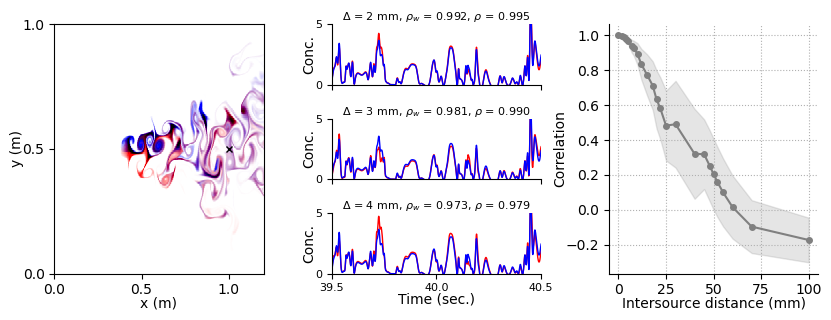

In [7]:
ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(Fcr, 40, [490000, 510000], y_lim = (0,5.01), t_wnd = [-0.5, 0.5], dt = 1)
ax_plume.set_xticks(arange(0,1.1,0.5)); ax_plume.set_yticks([0,0.5,1])
ax_traces[-1].set_xticks([39.5, 40, 40.5])
file_name = f"figs/plumes_demo_cr.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Figure showing the distribution of correlations

cr


bw


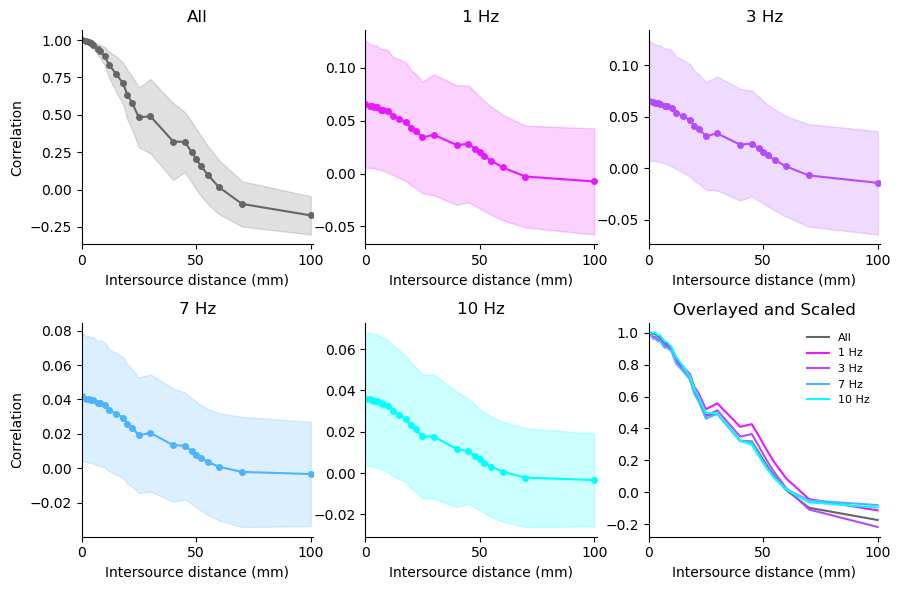

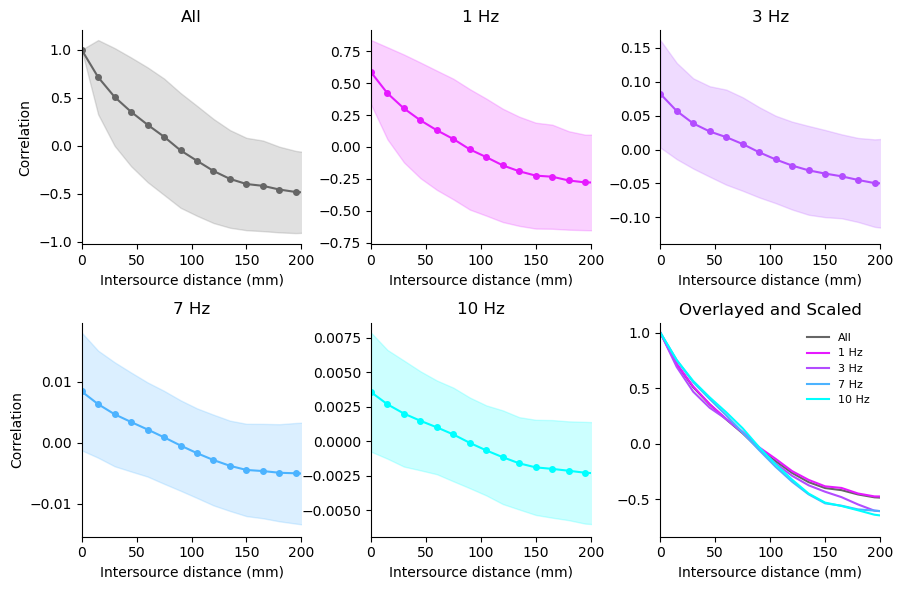

In [8]:
reload(fpf)
for k, F in data.items():
    print(k)
    sys.stdout.flush()
    if k in "bw":
        which_freqs = [1,3,7,10]
        labs = [f"{f} Hz" for f in which_freqs]
        cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f/10) for f in which_freqs])})
        slices = {"All":slice(1,10000)}
        slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, F.freqs2inds(which_freqs))})
        ax = fpf.plot_correlations(F.rho, xl = (0, 120), slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
        [(axi.set_xlabel("Intersource distance (mm)"), axi.set_xticks(arange(0,201,50))) for axi in ax]
        file_name = f"figs/corr_components_{k}.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))
    elif k == "cr":
        which_freqs = [1,3,7,10]
        labs = [f"{f} Hz" for f in which_freqs]
        cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f/10) for f in which_freqs])})
        slices = {"All":slice(1,10000)}
        slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, F.freqs2inds(which_freqs))})
        ax = fpf.plot_correlations(F.rho, xl = (0, 120), slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
        [(axi.set_xlabel("Intersource distance (mm)"), axi.set_xlim(0,101), axi.set_xticks(arange(0,101,50))) for axi in ax]
        file_name = f"figs/corr_components_{k}.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

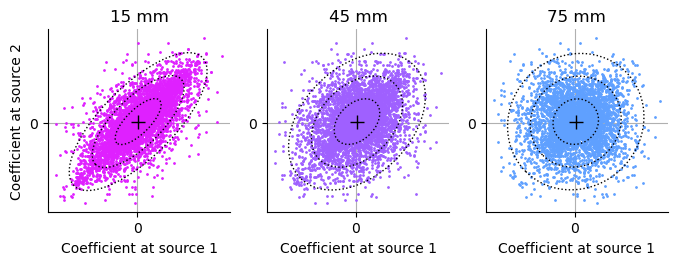

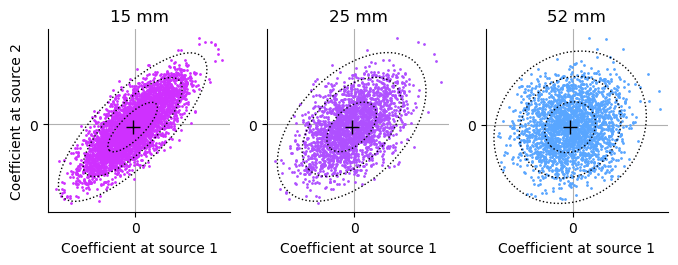

In [9]:
reload(fpf)
which_freqs = {"bw":5,       "cr":10}
which_idists= {"bw":[0,2,4], "cr":[8,12,18]}
dcol_scales = {"bw":120000,  "cr":80000}
for name, F in sorted(data.items()):
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    fpf.plot_coef1_vs_coef2([F.ss, F.cc],
                            ifreq,
                            F.pairs,
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    file_name = f"figs/coef_vs_coef_{name}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Supplementary Information

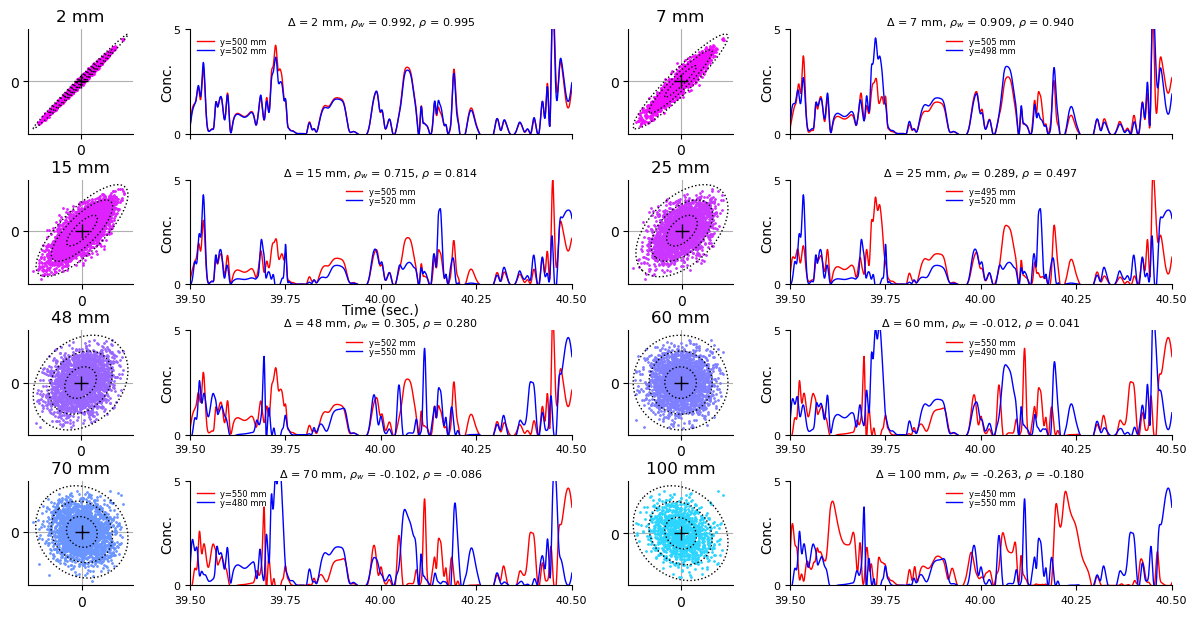

<Figure size 800x300 with 0 Axes>

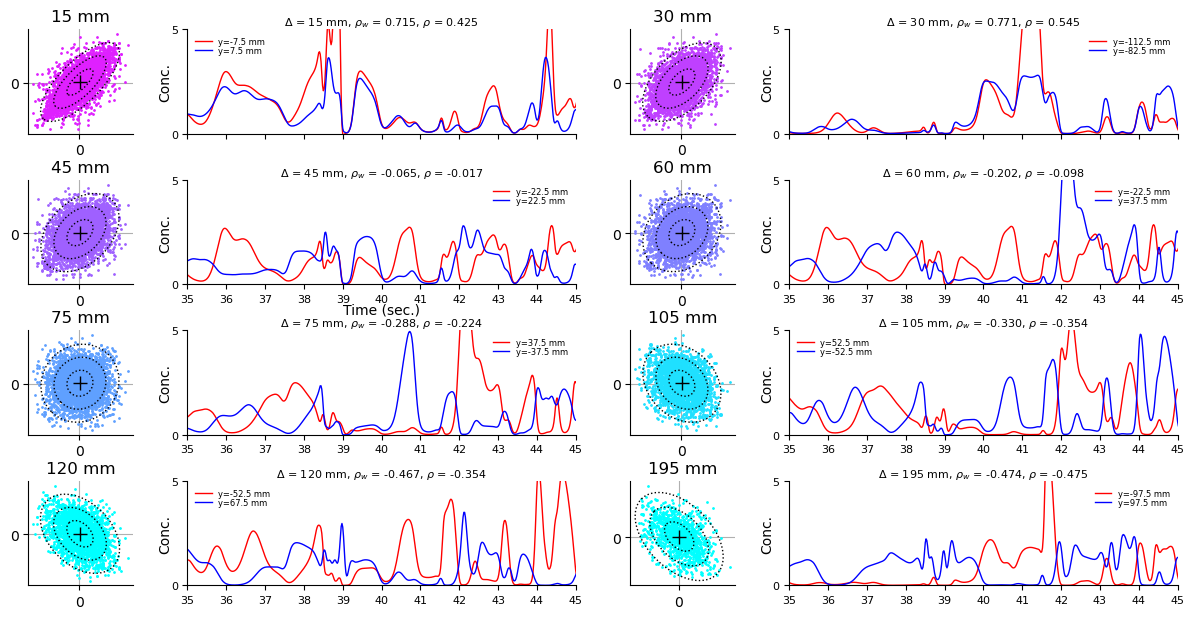

<Figure size 800x300 with 0 Axes>

In [10]:
reload(fpf)
freq      = {"bw":5, "cr":5}
idists    = {"bw":[0,1,2,3,4,6,7,12], "cr":[0,4,8,12,16,20,21,22]}
t_lim     = {"bw":[35, 45],       "cr":[39.5,40.5]}
dt        = {"bw":1,              "cr":0.25}
for k, F in data.items():
    # if k == "cr": continue
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k], n_per_row = 2, y_lim=[0,5], t_lim = t_lim[k], dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    file_name = f"figs/coefs_and_traces_{name}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));    

# Asymmetric Laplacian Fits

d=15000 @ Freq #  10: -np.log10(p) = 31.977
d=30000 @ Freq #  10: -np.log10(p) = 18.155
d=45000 @ Freq #  10: -np.log10(p) = 9.682


Wrote figs/alap_fits_bw.pdf.
d=2000 @ Freq #  10: -np.log10(p) = 2.531
d=25000 @ Freq #  10: -np.log10(p) = 1.708
d=52000 @ Freq #  10: -np.log10(p) = 0.462


Wrote figs/alap_fits_cr.pdf.


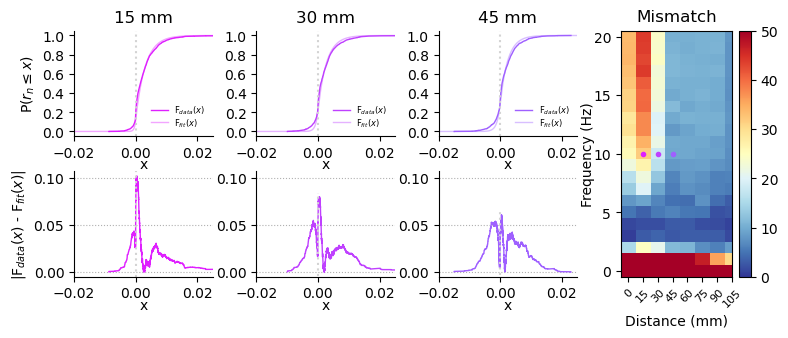

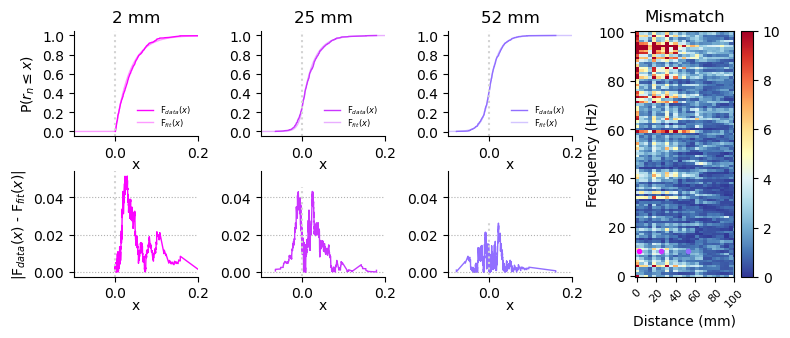

In [71]:
reload(fpf)
xl        = {"bw":[-0.02,0.025], "cr":[-0.1,0.2]}
idist     = {"bw":[0,1,2],       "cr":[0,12,18]}
ifreq_max = {"bw":21,            "cr":101}
vmax      = {"bw":50,            "cr":10}
hxmax     = {"bw":105,          "cr":100}
hmdxt     = {"bw":False,        "cr":True}
for name, F in sorted(data.items()):
    d = np.array(list(F.rho.keys()))
    d = np.sort(d[d>0])
    fpf.plot_alaplace_fits(F, d[idist[name]],
                           ifreq_lim = [0, ifreq_max[name]],
                           xl = xl[name],
                           which_ifreq = 10,
                           figsize=(8,3.5), vmax=vmax[name],
                           cm_heat = cm.RdYlBu_r,
                           heatmap_xmax = hxmax[name],
                           heatmap_default_xticks = hmdxt[name],
                           plot_dvals=True)
    file_name = f"figs/alap_fits_{name}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

Wrote figs/la_vs_s_fits_bw.pdf.


Wrote figs/la_vs_s_fits_cr.pdf.


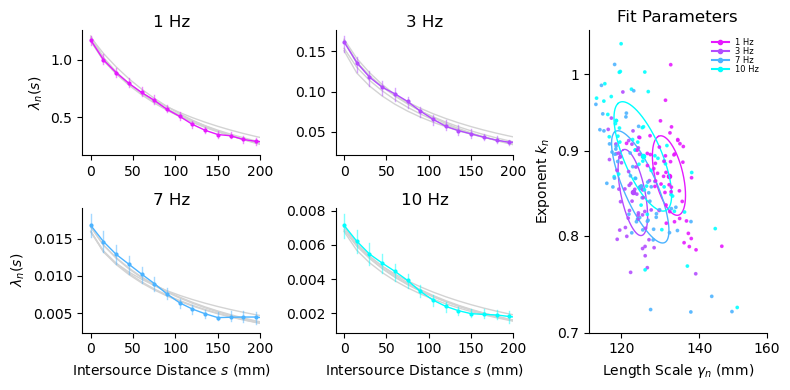

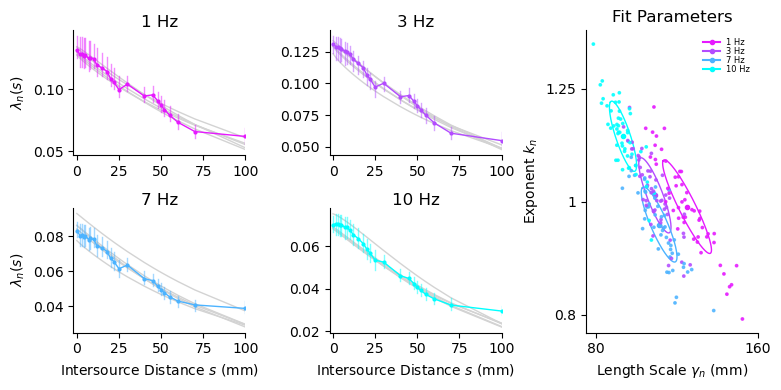

In [108]:
reload(fpft)
reload(fpf)
xl     = {"bw":(-10,200),   "cr": (-2, 50)}
ifreqs = {"bw":[1,3,7,10],  "cr": [1,3,7,10]}
xt     = {"bw":arange(0,201,50), "cr":arange(0,101,25)}
xtp    = {"bw":np.array([120,140,160]), "cr":np.array([80, 160])}
ytp    = {"bw":arange(0.7,1.05,0.1),    "cr":np.array([0.8,1,1.25])}
for k, F in sorted(data.items()):
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          xl = xl[k], figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          xt = log10(xtp[k]), yt = log10(ytp[k]),
                                          which_ifreqs = ifreqs[k])
    [(axi.set_xticks(xt[k]), (i>1) and axi.set_xlabel("Intersource Distance $s$ (mm)")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    file_name = f"figs/la_vs_s_fits_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

In [163]:
Fbw.compute_fisher_information_at_distances([100,200,1000]).shape

(3, 51, 26)

In [161]:
Fbw.compute_fisher_information()

/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:195: RuntimeWarning: divide by zero encountered in power
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:195: RuntimeWarning: divide by zero encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:195: RuntimeWarning: invalid value encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)


# Plot the Fisher Information

[4, 2, 12, 14]
8, Putting * at di=0.900, 0.900, 0.016 for bf=4
9, Putting * at di=1.000, 1.000, 0.014 for bf=4


Wrote figs/fisher_info_bw.pdf.
[30, 22, 86, 69]
0, Putting * at di=0.100, 0.100, 0.226 for bf=30
1, Putting * at di=0.200, 0.200, 0.098 for bf=30
2, Putting * at di=0.300, 0.300, 0.060 for bf=30
3, Putting * at di=0.400, 0.400, 0.043 for bf=30
4, Putting * at di=0.500, 0.500, 0.033 for bf=30
19, Putting * at di=20.000, 20.000, 0.001 for bf=86


Wrote figs/fisher_info_cr.pdf.


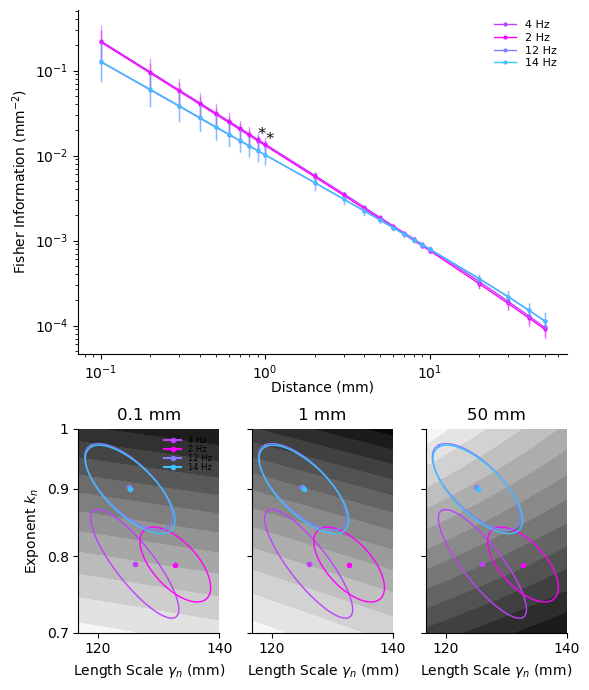

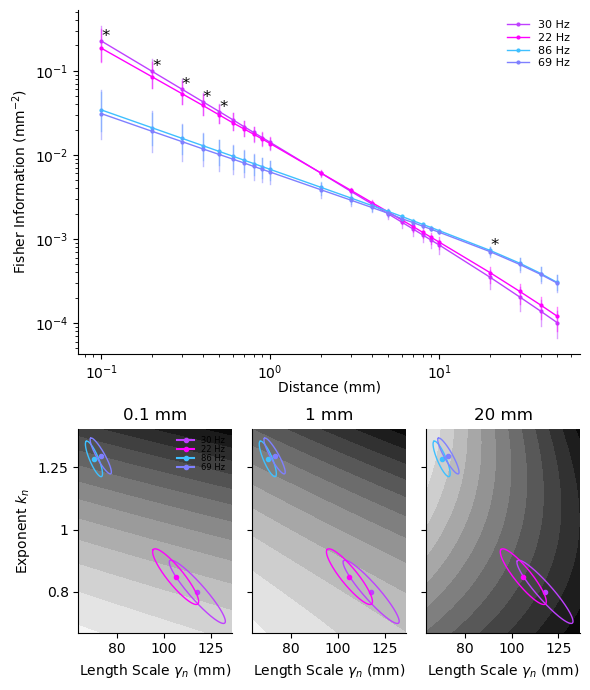

In [156]:
reload(fpf)
xtp["bw"] = [120, 140]
xtp["cr"] = [80, 100, 125]
ifreqs["cr"] = [10,20,30,40]
freq_max={"bw":20, "cr":100}
colscale = {"bw":10, "cr":40}
d_vals = {"bw":[0.1,1,50], "cr":[0.1,1,20]}
for k, F in sorted(data.items()):
#    if k == "cr": continue
    figure(figsize=(6,7))
    Ibs = fpf.plot_fisher_information(F,                           
                                      d_lim=[100,50000],
                                      d_range = list(range(100,1000,100)) + list(range(1000,10000,1000))+list(range(10000,60000,10000)),
                                      d_scale = 1000,
                                      d_vals = np.array(d_vals[k])*1000,
                                      d_space_fun = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                      which_ifreqs = ifreqs[k],
                                      x_stagger = lambda x, i: x,
                                      fi_scale = 1, plot_fun = plt.loglog,
                                      log_scale = True,
                                      freq_max = freq_max[k],
                                      colfun = lambda f: cm.cool_r(f/colscale[k]),
                                      xt = log10(xtp[k]), yt = log10(ytp[k])
    )
    tight_layout(h_pad=1)
    file_name = f"figs/fisher_info_{k}.pdf"
    PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

In [147]:
from scipy.stats import ttest_1samp, mannwhitneyu

In [150]:
f = [12,14]
a = Ibs[f[0],1:,-1]
b = Ibs[f[1],1:,-1]
print(ttest_1samp(Ibs[f[0],1:,-1] - Ibs[f[1],1:,-1],0,alternative='greater'))
print(mannwhitneyu(Ibs[f[0],1:,-1]- Ibs[f[1],1:,-1],0,alternative='greater'))

Ttest_1sampResult(statistic=6.71100605483634, pvalue=9.301268961522383e-09)
MannwhitneyuResult(statistic=41.0, pvalue=0.196078431372549)


# Plot the Power in each Signal

Wrote figs/spectra.pdf.


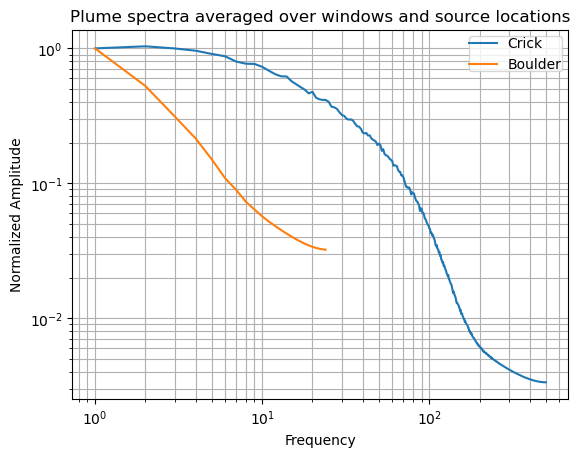

In [68]:
from numpy import fft
from scipy.signal import stft

for k, F in data.items():
    f = []
    for _, s in F.sims.items():
        fr, ti, S = stft(s.data[:,0], fs = F.fs, window='boxcar',
                         nperseg=F.fs, noverlap=F.fs//2, boundary=None, padded=False)
        f.append(np.abs(S))
        
    f = np.array(f)
    a = np.mean(f,axis=-1).mean(axis=0)    
    loglog(fr[fr<F.fs/2][1:],a[fr<F.fs/2][1:]/a[1], label="Crick" if k=="cr" else "Boulder")
legend(borderpad=0)
xlabel("Frequency")
ylabel("Normalized Amplitude")
title("Plume spectra averaged over windows and source locations")
grid(True, which='both')
file_name = f"figs/spectra.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));